## Image classification

Za domácí úkol budete mít vytvořit si vlastní libovolný dataset na image classfication task, abyste si vyzkoušeli, že vyrábět data není úplně snadné. Dataset by měl mít aspoň 5 různých tříd ke klasifikaci a ke každé nějaké rozumné desítky obrázků.

Až budete mít data, tak si na nich zkuste image classification task. Jak už jsem zmínila výše, trénovat celou konvoluční síť od začátku by bylo početně náročné, proto budete mít za úkol si vybrat 3 z už predtrénovaných modelů například [odsud](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/) a přetrénovat je tak, aby uměly klasifikovat vámi vytvořená data.

Můžete si na vašich datech i zkusit natrénovat podobnou (klidně i stejnou) jednoduchou konvoluční síť, kterou jsme používali před na MNISTu výše a schválně se podívat, jak moc bude špatná oproti těm už předtrénovaným.

Své řešení mi pošlete emailem do stanoveného deadline. Pro sepsání popisu vašeho datasetu, zvolených modelů a rozboru výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/08_konvoluce/DU2_konvolucni_site.pdf). Řešení by mělo obsahovat:
1. slovní popis vašich dat (jaké máte labely, kolik každý obsahuje obrázků, velikost obrázků, zdůvodnění volby datasetu)
2. váš kód
3. slovní popis výsledků a porovnání modelů (jaké jste použili, jak byl který úspěšný (accuraccy všech modelů na testovací množině, sepsaná třeba v nějaké pěkné tabulce) a který byl nejlepší)
4. vámi vytvořený předzpracovaný dataset (obrázky by měly být malé, takže by neměl být problém s posláním)

Pár tipů
- bylo by dobré mít u všech tříd stejný počet obrázků
- obrázky bude potřeba převést do nějakého jednotného rozumně malého rozměru (například 128 x 128 pixelů)
- když budete používat předtrénované sítě, tak ty vaše obrázky by měly být stejně velké jako ty, na kterých byla trénovaná ta  síť původně
- zároveň bude potřeba je rozdělit na dvě disjunktní množiny -- trénovací a testovací (trénovací na přetrénovaní modelů a testovací na jejich vyhodnocení)
- model se dá přetrénovat například tak, že si nahradíte poslední nebo několik posledních vrstev vlastními, které budete přetrénovávat podle vašich dat
- pokud se vám model nedaří přetrénovat, aby dosahoval nějakých rozumných výsledků, zkuste použít nějakou augmentaci dat a trénovat na větších datech


### Solution


In [1]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
%matplotlib inline
from tensorflow.keras.layers import Flatten, Dense, Activation, Resizing
from tensorflow.keras.activations import linear, relu
from tensorflow.nn import softmax

In [2]:
import keras.applications.resnet as resnet
import keras.applications.mobilenet as mobilenet
import keras.applications.xception as xception

In [3]:
def load_dataset(path, shape=(224,224), test_split=0.2):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        seed=42,
        batch_size=None,
        image_size=shape,
        validation_split=test_split,
        subset="both",
    )

In [4]:
def preprocess_image(image, network):
    if network == "ResNet50":
        return resnet.preprocess_input(image)
    elif network == "MobileNet":
        return mobilenet.preprocess_input(image)
    elif network == "Xception":
        return xception.preprocess_input(image)
    else:
        raise ValueError("Unknown network")

In [5]:
def preprocess_input(dataset, network):
    data = []
    target = []

    for image, label in dataset:
        data.append(preprocess_image(image, network))
        target.append(label)
        
    return np.array(data), np.array(target)

In [6]:
def create_model(base_model, classes):
    base_model.trainable = False
    
    model = keras.models.Sequential([])
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(units=classes, activation=linear, name='logits'))
    model.add(Activation(activation=softmax))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
def retrian_model(model, train_data, train_target , epochs=3, batch_size = 20):
    history = model.fit(train_data, train_target, epochs=epochs, validation_split=0.2, batch_size=batch_size).history
    return model, history

### Training Models

In [17]:
networks = {
    'ResNet50': resnet.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    'MobileNet': mobilenet.MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    'Xception': xception.Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
}
histories = {}
models = {}

for network in networks.keys():
    print(f"***** Retraining {network} model ***** \n")

    base_model = networks[network]

    print(f"> Loading dataset\n")
    train_ds, test_ds = load_dataset("dataset", shape=base_model.input_shape[1:3], test_split=0.2)
    
    print(f"\n> Preprocessing data\n")
    train_data, train_target = preprocess_input(train_ds, network)
    test_data, test_target = preprocess_input(test_ds, network)

    classes = len(train_ds.class_names)

    print(f"> Training Model\n")
    model = create_model(base_model, classes)
    model, history = retrian_model(model, train_data, train_target, epochs=5, batch_size=20)

    models[network] = model
    histories[network] = history

    print("\n> Evaluating train data")
    _, train_acc = model.evaluate(train_data, train_target)
    print(f"\n -  Train data accuracy: {train_acc*100:.2f}%")

    print("\n> Evaluating test data")
    _, test_acc = model.evaluate(test_data, test_target)
    print(f"\n- Test data accuracy: {test_acc*100:.2f}%")
    print("_"*150)

***** Retraining ResNet50 model ***** 

> Loading dataset

Found 190 files belonging to 5 classes.
Using 152 files for training.
Using 38 files for validation.

> Preprocessing data

> Training Model

Epoch 1/5
7/7 [==============================] - 30s 3s/step - loss: 1.6541 - accuracy: 0.8099 - val_loss: 0.9138 - val_accuracy: 0.8710
Epoch 2/5
7/7 [==============================] - 19s 3s/step - loss: 0.2916 - accuracy: 0.9752 - val_loss: 0.4338 - val_accuracy: 0.9355
Epoch 3/5
7/7 [==============================] - 18s 3s/step - loss: 1.4183e-05 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9677
Epoch 4/5
7/7 [==============================] - 19s 3s/step - loss: 1.3612e-05 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 0.9677
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 5.3324e-06 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9677

> Evaluating train data
5/5 [==============================] - 18s 3s/step - loss: 0.0224 - accuracy:

##### Show plots

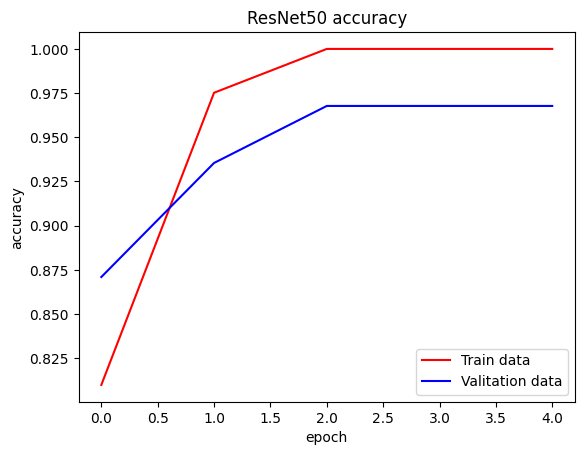

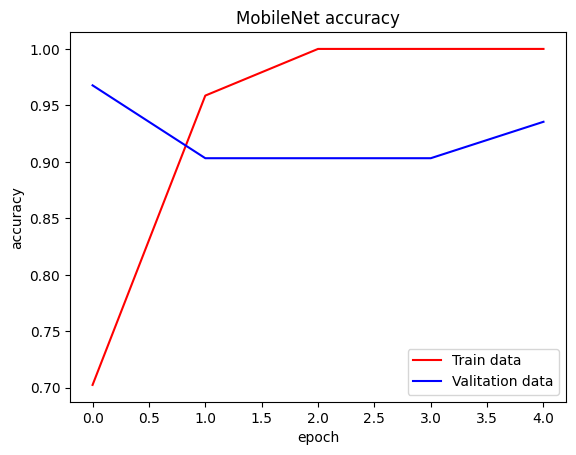

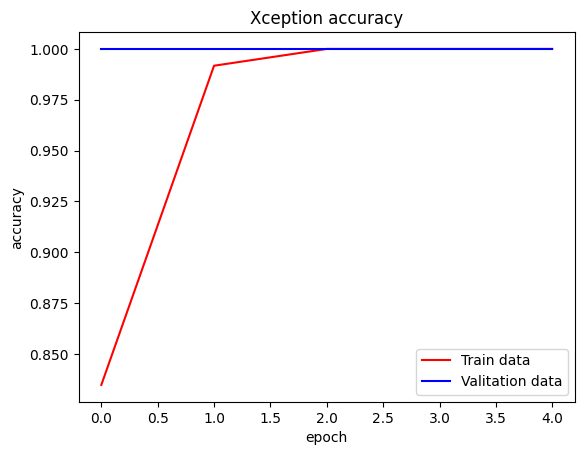

In [18]:
for network in networks.keys():
    plt.plot(histories[network]['accuracy'], label="Train data", color='red')
    plt.plot(histories[network]['val_accuracy'], label="Valitation data", color='blue')

    plt.title(f'{network} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.show()